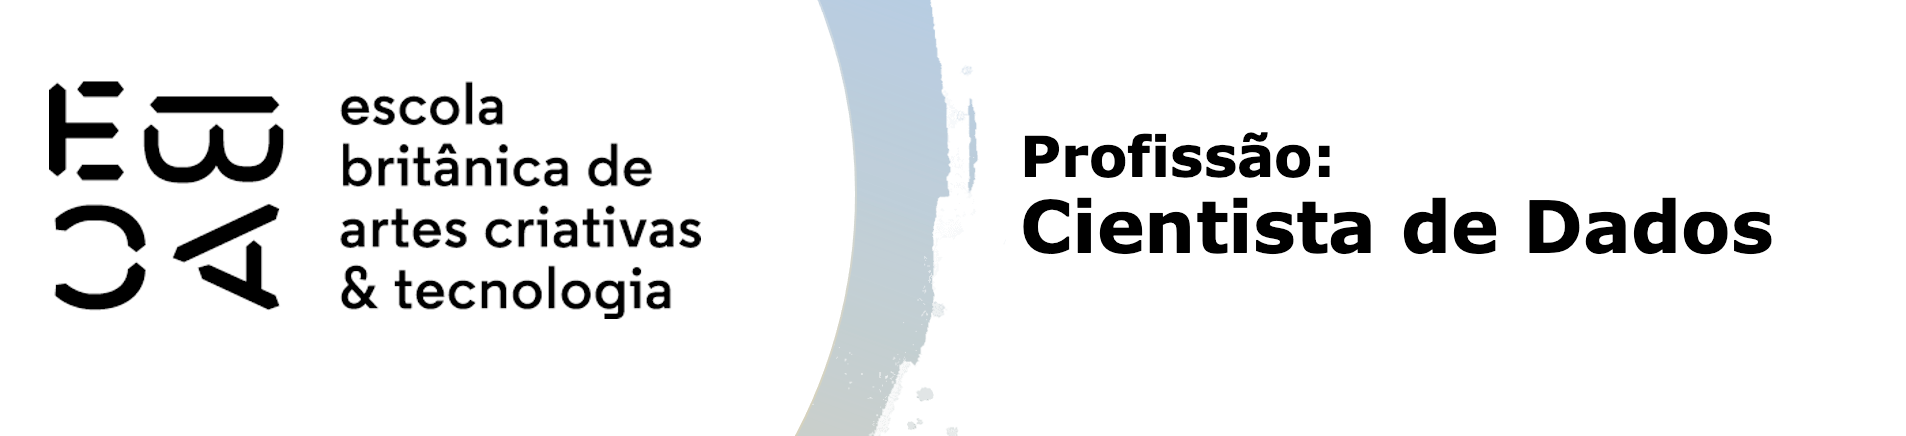

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelo e previsão de renda que você fez para esta base. 

- Substitua missings pela média     
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [9]:
import pandas as pd
#import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.graphics.regressionplots import influence_plot

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

import warnings
warnings.filterwarnings('ignore') 

df = pd.read_csv('previsao_de_renda_II.csv')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [10]:
df.loc[df['tempo_emprego'].isna(), 'tempo_emprego'] = df['tempo_emprego'].mean()

In [11]:
df.reset_index(inplace=True)
df['data_ref'] = pd.to_datetime(df['data_ref'])
df.drop(columns=['index', 'level_0'], inplace=True)

In [12]:
first_year = df['data_ref'].dt.year.min()
last_date = df['data_ref'].iat[-1]

In [13]:
df['log_renda'] = np.log(df['renda'])

In [14]:
reg_formula = 'log_renda ~ tempo_emprego + idade + sexo + posse_de_imovel + tipo_renda + educacao'
reg = smf.ols(reg_formula, data=df).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                 4.049e+04
Date:                Wed, 04 Jun 2025   Prob (F-statistic):               0.00
Time:                        15:58:11   Log-Likelihood:            -1.0645e+06
No. Observations:              750000   AIC:                         2.129e+06
Df Residuals:                  749987   BIC:                         2.129e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           7.6808      0.012    617.006      0.000       7.656       7.705
sexo[T.M]                           0.1311      0.003     51.544      0.000       0.126       0.136
posse_de_imovel[T.S]                0.1862      0.002     74.893      0.000       0.181       0.191
tipo_renda[T.Bolsista]             -0.1676      0.052     -3.248      0.001      -0.269      -0.066
tipo_renda[T.Empresário]            0.1523      0.003     52.167      0.000       0.147       0.158
tipo_renda[T.Pensionista]          -0.2963      0.004    -71.373      0.000      -0.304      -0.288
tipo_renda[T.Servidor público]      0.1450      0.004     33.721      0.000       0.137       0.153
educacao[T.Médio]                   0.0565      0.011      5.153      0.000       0.035       0.078
educacao[T.Pós graduação]           0.1235      0.037      3.337      0.001       0.051       0.196
educacao[T.Superior completo]       0.0508      0.011      4.591      0.000       0.029       0.072
educacao[T.Superior incompleto]     0.0370      0.012      2.981      0.003       0.013       0.061
tempo_emprego                       0.1289      0.000    633.895      0.000       0.129       0.129
idade                               0.0033      0.000     23.340      0.000       0.003       0.004
==============================================================================
Omnibus:                     3974.334   Durbin-Watson:                   1.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2864.772
Skew:                          -0.023   Prob(JB):                         0.00
Kurtosis:                       2.701   Cond. No.                     2.05e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

In [15]:
is_test = df['data_ref'] >= last_date - pd.Timedelta(days=3*30)
df_test = df[is_test].copy()
df = df[~is_test]
df_test['log_renda'] = np.log(df_test['renda'])

In [16]:
df_test['pred'] = reg.predict(df_test)
df_test['resid'] = df_test['log_renda'] - df_test['pred']

df['pred'] = reg.predict(df)
df['resid'] = df['log_renda'] - df['pred']

<Axes: ylabel='Count'>

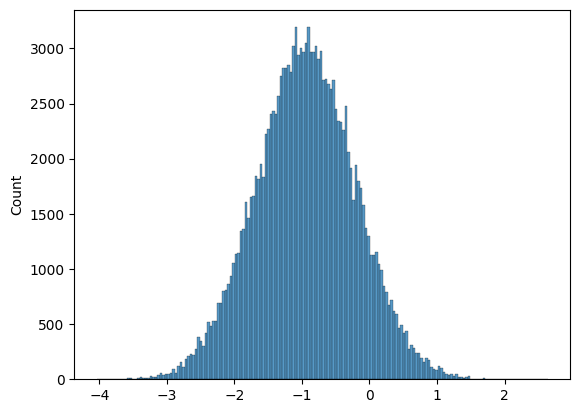

In [17]:
sns.histplot(df_test['log_renda'] - df_test['pred'])

In [19]:
(df_test['pred'] - df_test['log_renda']).mean()

np.float64(0.9427315269821527)

<Axes: xlabel='pred', ylabel='log_renda'>

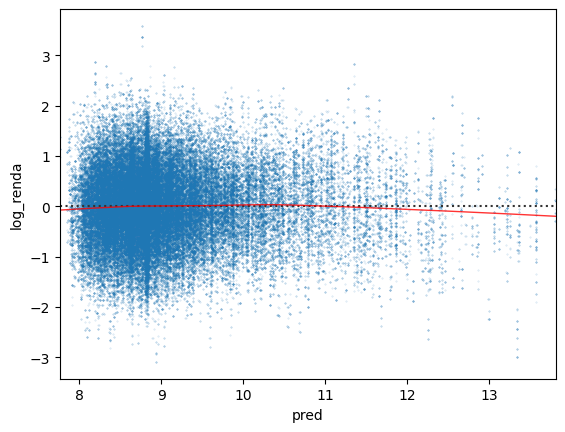

In [52]:
sns.residplot(
    data=df_test,
    x='pred',
    y='log_renda',
    lowess=True,
    scatter_kws={'alpha': 0.25, 's':.1},
    line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}
)

<Axes: xlabel='tempo_emprego', ylabel='log_renda'>

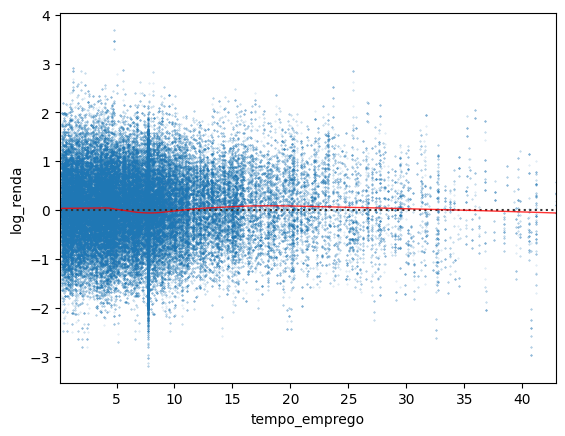

In [53]:
sns.residplot(
    data=df_test,
    x='tempo_emprego',
    y='log_renda',
    lowess=True,
    scatter_kws={'alpha': 0.25, 's':.1},
    line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}
)

<Axes: xlabel='idade', ylabel='log_renda'>

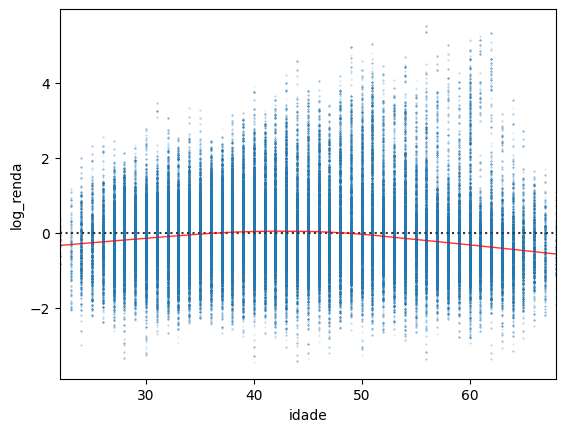

In [54]:
sns.residplot(
    data=df_test,
    x='idade',
    y='log_renda',
    lowess=True,
    scatter_kws={'alpha': 0.25, 's':.1},
    line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}
)

<Axes: xlabel='sexo', ylabel='resid'>

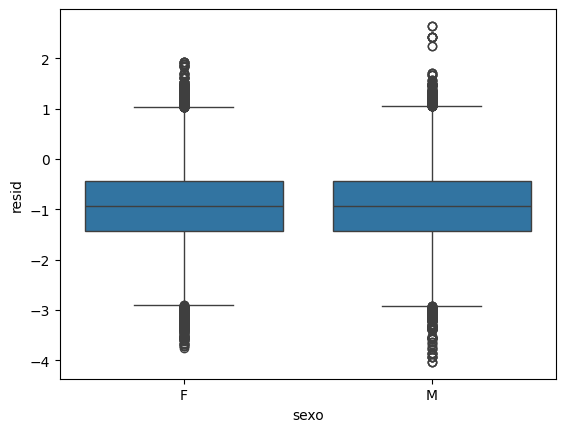

In [55]:
sns.boxplot(
    data=df_test,
    x='sexo',
    y='resid'
)

<Axes: xlabel='posse_de_imovel', ylabel='resid'>

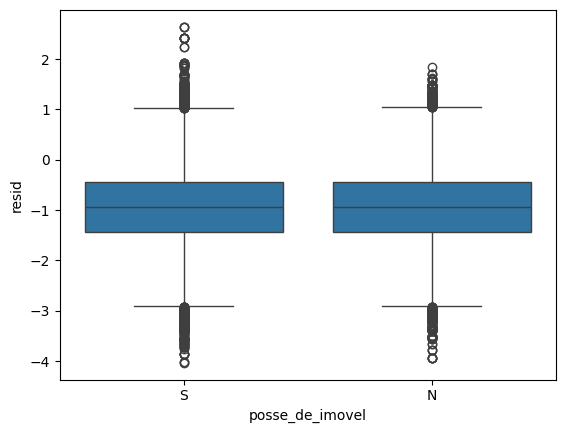

In [56]:
sns.boxplot(
    data=df_test,
    x='posse_de_imovel',
    y='resid'
)

<Axes: xlabel='tipo_renda', ylabel='resid'>

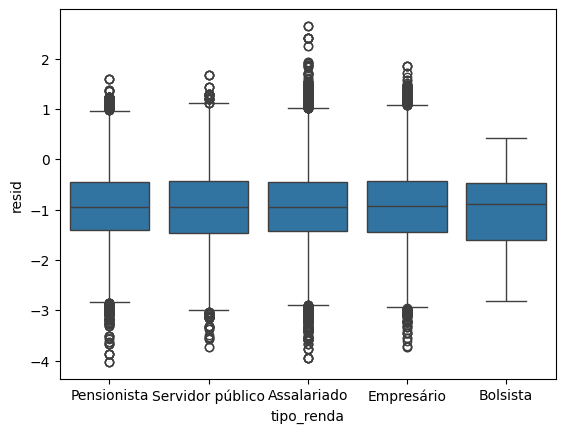

In [57]:
sns.boxplot(
    data=df_test,
    x='tipo_renda',
    y='resid'
)

<Axes: xlabel='educacao', ylabel='resid'>

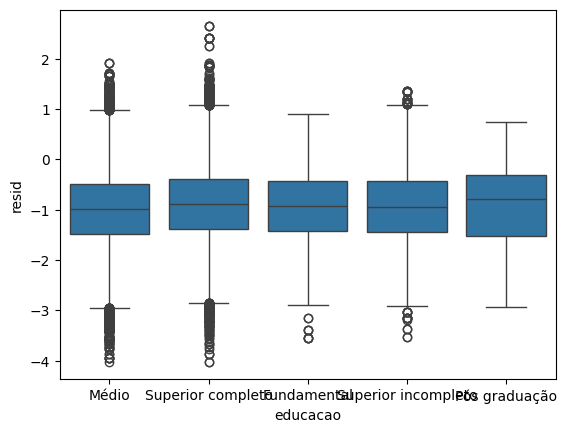

In [58]:
sns.boxplot(
    data=df_test,
    x='educacao',
    y='resid'
)

In [20]:
df_test['mes'] = df_test['data_ref'].dt.month + (df_test['data_ref'].dt.year - first_year) * 12
df['mes'] = df['data_ref'].dt.month + (df['data_ref'].dt.year - first_year) * 12

<Axes: xlabel='mes', ylabel='resid'>

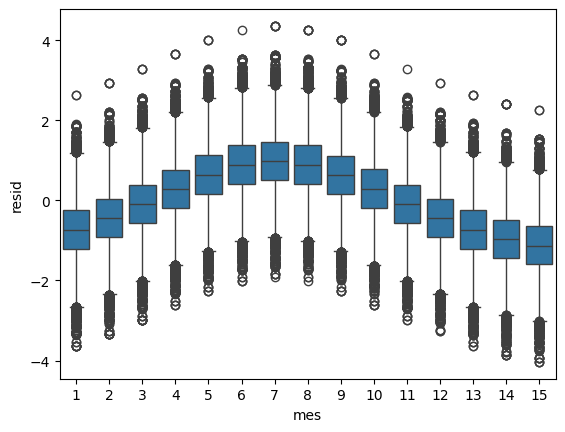

In [21]:
sns.boxplot(
    data=pd.concat((df, df_test)),
    x='mes',
    y='resid'
)

Observamos que os resíduos possuem distribuição normal. Existe uma relação de dependência com relação ao mês de referência. Isso explica o viés do erro na base de testes.

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

In [76]:
reg_sample = smf.ols(reg_formula, data=df.sample(n=32768)).fit()

In [95]:
st_res = reg_sample.outlier_test().student_resid

<Axes: ylabel='student_resid'>

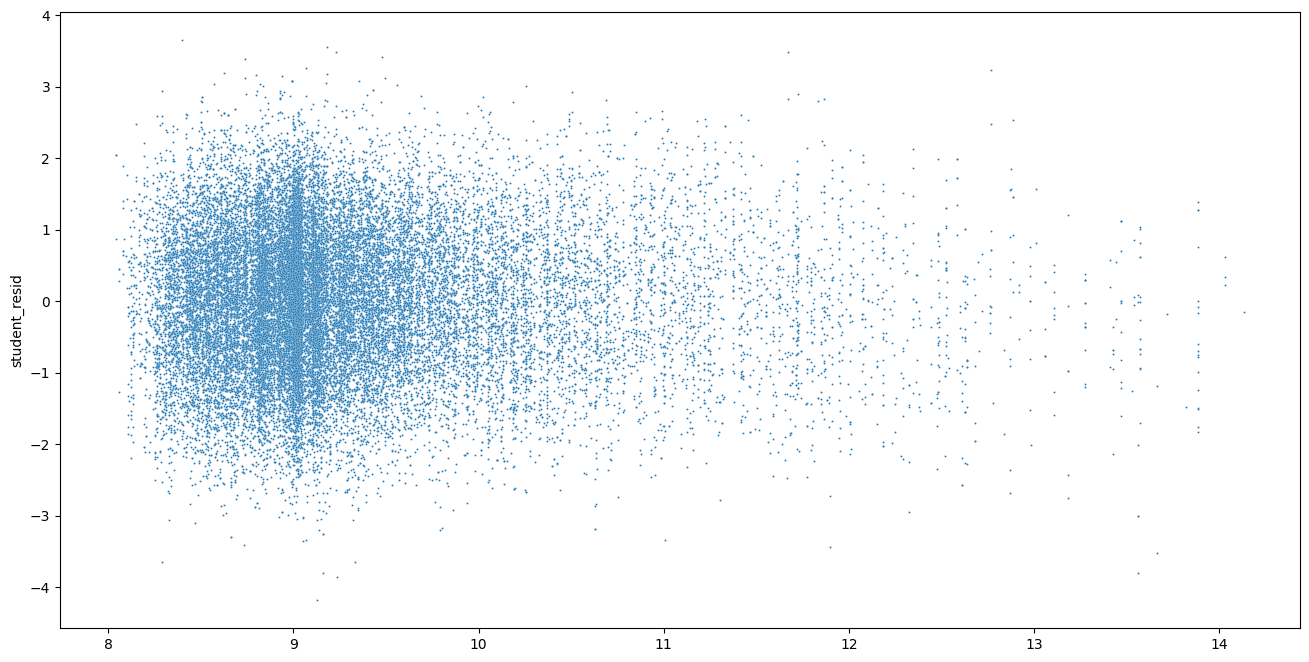

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.scatterplot(x=reg_sample.predict(), y=st_res, alpha=1, s=2, ax=ax)

Apesar de ter resíduos bem altos, parecem não interferir no modelo significativamente. Vamos ver o que o gráfico de influências nos diz:

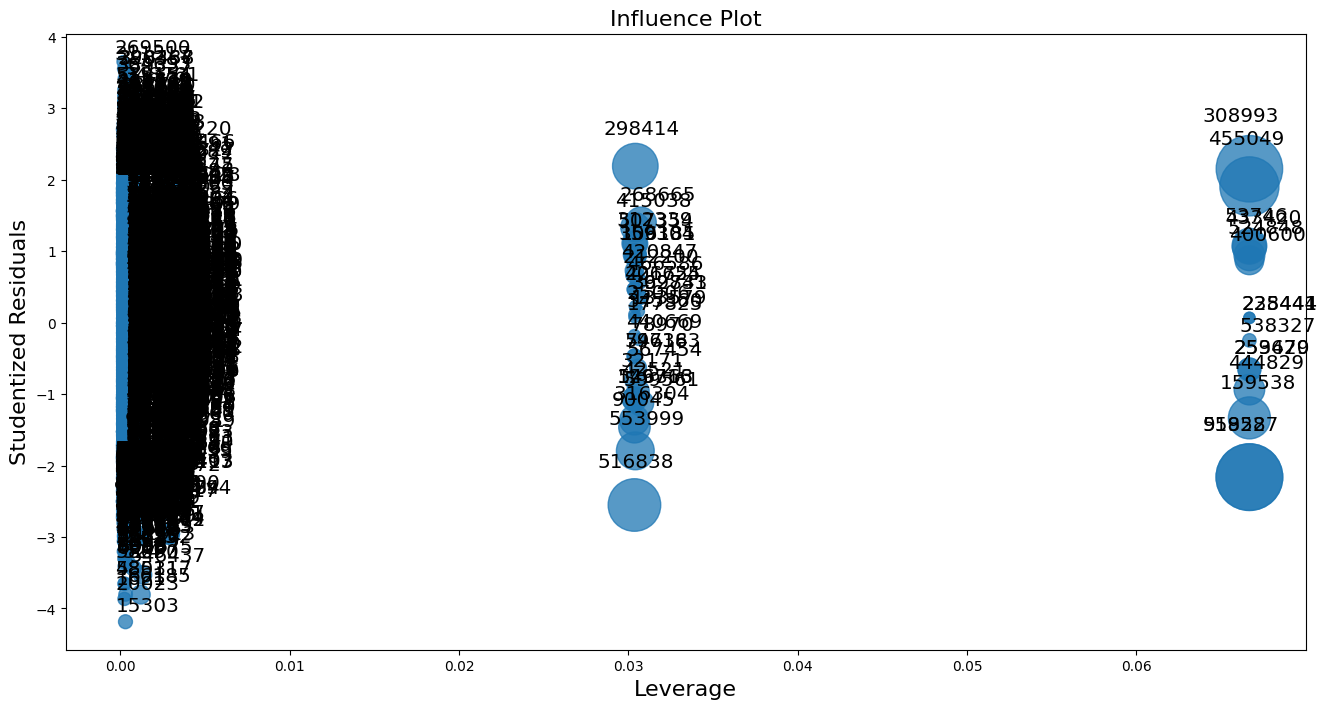

In [ ]:
from statsmodels.graphics.regressionplots import influence_plot

fig, ax = plt.subplots(figsize=(16, 8))
fig = influence_plot(reg_sample, criterion='cooks', ax=ax)


Podemos observar que os pontos com maior resíduo estudentizado estão muito próximos à média, portanto têm pouca alavancagem. 
Porém, temos alguns pontos com uma influência razoável. Acredito que não vale a pena removê-los.

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

In [78]:
num_vars = [
    'tempo_emprego', 
    'idade'
]
cat_vars = [
    'sexo', 
    'posse_de_imovel', 
    'tipo_renda', 
    'educacao'
]
df[num_vars].corr()

,tempo_emprego,idade
tempo_emprego,1.00000,0.25193
idade,0.25193,1.00000


In [79]:
df[num_vars].corr(method='spearman')

,tempo_emprego,idade
tempo_emprego,1.000000,0.301418
idade,0.301418,1.000000


In [96]:
df_dum = pd.get_dummies(df[cat_vars + num_vars], drop_first=True)

In [112]:
vars_vif = pd.DataFrame()
vars_vif['VIF Factor'] = [vif(df_dum, i) for i in range(df_dum.shape[1])]
vars_vif['Feature'] = df_dum.columns

vars_vif.round(2)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

As variáveis com maior VIF são idade e educacao_médio. A última é uma dummy de uma variável categórica importante para o modelo, portanto, 
não vamos tratar por enquanto. 
Quanto à idade, já podemos concluir que possui uma correlação consideravél com tempo_emprego, o que faz sentido. 

In [113]:
import scipy.stats as ss 

def cramer_v_raw(x,y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    result=-1
    if len(x.value_counts())==1 :
        print("First variable is constant")
    elif len(y.value_counts())==1:
        print("Second variable is constant")
    else:   
        conf_matrix=pd.crosstab(x, y)

        if conf_matrix.shape[0]==2:
            correct=False
        else:
            correct=True

        chi2 = ss.chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r,k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result=np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
        return result

In [114]:
def cramer_v(x, y, max_cat=5):
    if (np.dtype(x) in {np.dtype('float64'), np.dtype('int64')}) \
        and (len(np.unique(x)) > max_cat):
            x_ = pd.qcut(x, max_cat)
#             print('#########')
    else: x_ = x
    if (np.dtype(y) in {np.dtype('float64'), np.dtype('int64')}) \
        and (len(np.unique(y)) > max_cat):
            y_ = pd.qcut(y, max_cat)
    else: y_ = y
    return cramer_v_raw(x_ ,y_)

In [115]:
vars = num_vars + cat_vars
cramer_mat = pd.DataFrame(
    np.zeros( ((len(vars)), len(vars)) ),
    columns=vars,
    index=vars
)

for var1 in vars:
    for var2 in vars:
        cramer_mat.loc[var1, var2] = cramer_v(df[var1], df[var2])

In [116]:
cramer_mat

,tempo_emprego,delta_idade_emprego,sexo,posse_de_imovel,tipo_renda,educacao
tempo_emprego,1.000000,0.199885,0.157900,0.078671,0.366814,0.059312
delta_idade_emprego,0.199885,1.000000,0.106461,0.093425,0.171580,0.085430
sexo,0.157900,0.106461,1.000000,0.055238,0.190153,0.021655
posse_de_imovel,0.078671,0.093425,0.055238,1.000000,0.098883,0.056585
tipo_renda,0.366814,0.171580,0.190153,0.098883,1.000000,0.093570
educacao,0.059312,0.085430,0.021655,0.056585,0.093570,1.000000


Pela matriz de coeficientes V de Cramer, podemos observar que tipo_renda possui uma relação de multicolinearidade ainda mais forte com a idade.

## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

Ouliers

Acabei decidindo por não remover outliers pelos seguintes motivos:
O conjunto de dados é muito grande, o que diminui a probabilidade da remoção de outliers melhorar o modelo amostra.
Pelo motivo anterior, a análise de outliers teve que ser feita em uma amostra dos pontos. Isso dificulta a remoção de outliers similares fora da amostra.
Os pontos de maior influência encontrados possuem influência razoável e estão relativamente bem dstribuidos.



Dependência

Entendo que primeiro podemos resolver o problema da dependência entre os resíduos e mês de referência. Para isso, vamos extrair a média do log(renda) para cada mês.

In [22]:
log_renda_mes = pd.concat((df, df_test)).groupby('mes')['log_renda'].mean()
df['log_renda_mes'] = df['mes'].map(log_renda_mes)
df_test['log_renda_mes'] = df_test['mes'].map(log_renda_mes)

Agora temos duas opções: usar log_renda_mes como variável explicativa ou substituir a variável resposta por delta_log_renda, sendo que delta_log_renda = log_renda - log_renda_mes. 

A vantagem da segunda opção é que além de permitir prever a renda a partir da estimativa da média mensal, possibilita comparar clientes entre si sem a necessidade de tal estimativa.

In [24]:
df['delta_log_renda'] = df['log_renda'] - df['log_renda_mes']
df_test['delta_log_renda'] = df_test['log_renda'] - df_test['log_renda_mes']

Multicolinearidade
Agora, vamos substituir a variável explicativa idade por idade_emprego.

In [25]:
df['idade_emprego'] = df['idade'] - df['tempo_emprego']
df_test['idade_emprego'] = df_test['idade'] - df_test['tempo_emprego']

Por fim, calculamos a diferença entre idade_emprego e idade_emprego_tr, sendo que idade_emprego_tr é a média de idade_emprego por tipo_renda.

In [26]:
idade_emprego_tr = pd.concat((df, df_test)).groupby('tipo_renda')['idade_emprego'].mean()
df['idade_emprego_tr'] = df['tipo_renda'].map(idade_emprego_tr)
df_test['idade_emprego_tr'] = df_test['tipo_renda'].map(idade_emprego_tr)

In [27]:
df['delta_idade_emprego'] = df['idade_emprego'] - df['idade_emprego_tr']
df_test['delta_idade_emprego'] = df_test['idade_emprego'] - df_test['idade_emprego_tr']

Agora vamos avaliar se os ajustes feitos melhoraram o modelo:

In [28]:
num_vars = [
    'tempo_emprego', 
    'delta_idade_emprego'
]
cat_vars = [
    'sexo', 
    'posse_de_imovel', 
    'tipo_renda', 
    'educacao'
]

In [29]:
df_dum = pd.get_dummies(df[cat_vars + num_vars], drop_first=True)

vars_vif = pd.DataFrame()
vars_vif['VIF Factor'] = [vif(df_dum, i) for i in range(df_dum.shape[1])]
vars_vif['Feature'] = df_dum.columns

vars_vif.round(2)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

O Problema da multicolinearidade resolvido! Notamos que até a dummy educacao_Médio dexou de ter um VIF tão alto.

In [30]:
formula = f"delta_log_renda ~ {' + '.join(num_vars + cat_vars)}"
reg_b = smf.ols(formula, data=df).fit()
reg_b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        delta_log_renda   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                 6.329e+04
Date:                Wed, 04 Jun 2025   Prob (F-statistic):               0.00
Time:                        16:00:06   Log-Likelihood:            -6.5264e+05
No. Observations:              600000   AIC:                         1.305e+06
Df Residuals:                  599987   BIC:                         1.305e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -1.2585      0.009   -139.285      0.000      -1.276      -1.241
sexo[T.M]                           0.1366      0.002     66.877      0.000       0.133       0.141
posse_de_imovel[T.S]                0.1833      0.002     91.884      0.000       0.179       0.187
tipo_renda[T.Bolsista]             -0.2359      0.041     -5.730      0.000      -0.317      -0.155
tipo_renda[T.Empresário]            0.1404      0.002     59.915      0.000       0.136       0.145
tipo_renda[T.Pensionista]          -0.2267      0.003    -84.680      0.000      -0.232      -0.221
tipo_renda[T.Servidor público]      0.1163      0.003     33.614      0.000       0.110       0.123
educacao[T.Médio]                   0.0107      0.009      1.216      0.224      -0.007       0.028
educacao[T.Pós graduação]           0.1379      0.030      4.607      0.000       0.079       0.197
educacao[T.Superior completo]       0.1438      0.009     16.204      0.000       0.126       0.161
educacao[T.Superior incompleto]     0.0453      0.010      4.554      0.000       0.026       0.065
tempo_emprego                       0.1331      0.000    791.055      0.000       0.133       0.133
delta_idade_emprego                 0.0041      0.000     36.442      0.000       0.004       0.004
==============================================================================
Omnibus:                       86.650   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.544
Skew:                          -0.006   Prob(JB):                     1.32e-20
Kurtosis:                       3.059   Cond. No.                         467.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
from sklearn.metrics import r2_score

In [32]:
r2_score(df_test['delta_log_renda'], reg_b.predict(df_test))

0.5589812694405077

O novo Rquadrado na base de testes não só é igual à nova base de treino com é muito melhor que o da base de treino anterior.
Com isso, concluímos que os ajustes feitos aqui melhoraram o modelo.